2021.03.19 運禽車軌跡

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, shape
import folium
from folium import plugins
import datetime
from polib.CsvEngn import *
%matplotlib inline

# 讀入 單一車輛/司機 資料

In [2]:
path = r"C:\Users\EMCT_Jeff\Desktop\6860422340_UV-993楊志成_1001_1015.csv"
df = read_data_dir_fPathExt(path)

  >> 讀取:: C:\Users\EMCT_Jeff\Desktop\6860422340_UV-993楊志成_1001_1015.csv


In [3]:
df.head()

,GPSDATETIME,Unnamed: 1,X,Y,ADDRESS,SPEED,COURSE
0,2020/10/01 00:00:52,1,120.457025,23.689542,630台灣雲林縣斗南鎮雲84鄉道,0,0
1,2020/10/01 00:02:22,1,120.457025,23.689542,630台灣雲林縣斗南鎮雲84鄉道,0,0
2,2020/10/01 00:05:22,1,120.457025,23.689542,630台灣雲林縣斗南鎮雲84鄉道,0,0
3,2020/10/01 00:05:52,1,120.457025,23.689542,630台灣雲林縣斗南鎮雲84鄉道,0,0
4,2020/10/01 00:08:22,1,120.457025,23.689542,630台灣雲林縣斗南鎮雲84鄉道,0,0


In [4]:
wgs84 = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.X, df.Y), crs=wgs84)

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


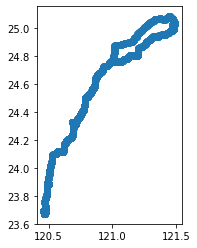

In [5]:
# 總行車軌跡
gdf.plot()

In [6]:
gdf.loc[:,"GPSDATETIME"] = pd.to_datetime(gdf.loc[:,"GPSDATETIME"])
gdf.loc[:,"date"] = gdf.loc[:,"GPSDATETIME"].dt.date

In [7]:
gdf.loc[:,"date"].unique()

array([datetime.date(2020, 10, 1), datetime.date(2020, 10, 2),
       datetime.date(2020, 10, 3), datetime.date(2020, 10, 4),
       datetime.date(2020, 10, 5), datetime.date(2020, 10, 6),
       datetime.date(2020, 10, 7), datetime.date(2020, 10, 8),
       datetime.date(2020, 10, 9), datetime.date(2020, 10, 10),
       datetime.date(2020, 10, 11), datetime.date(2020, 10, 12),
       datetime.date(2020, 10, 13), datetime.date(2020, 10, 14),
       datetime.date(2020, 10, 15)], dtype=object)

## 挑出有移動行為的日期

In [8]:
# 以X座標的變化來判斷當天是否有出車
date_X_nuniq_df = gdf[["date", "X"]].groupby("date").X.nunique().reset_index()
date_X_nuniq_df

,date,X
0,2020-10-01,2
1,2020-10-02,1
2,2020-10-03,1
3,2020-10-04,1
4,2020-10-05,546
5,2020-10-06,358
6,2020-10-07,529
7,2020-10-08,420
8,2020-10-09,524
9,2020-10-10,363


## 判斷為有值勤的日期: 當日不重複X座標大於100個

In [9]:
move_date_lst = date_X_nuniq_df.loc[date_X_nuniq_df.X>100, "date"]
move_date_lst

4     2020-10-05
5     2020-10-06
6     2020-10-07
7     2020-10-08
8     2020-10-09
9     2020-10-10
11    2020-10-12
12    2020-10-13
13    2020-10-14
14    2020-10-15
Name: date, dtype: object

## 挑選日期

In [10]:
# mask = gdf.loc[:,"date"].isin([datetime.date(2020, 10, 9)]) 

#觀察每一天
mask = gdf.loc[:,"date"].isin(move_date_lst)
gdf_pic = gdf[mask].reset_index(drop=True)

計算點位之間的時間差、距離差

In [11]:
gdf_pic.loc[:,"position_lag1"] = gdf_pic.loc[:,"geometry"].shift(periods=1)
gdf_pic.to_crs('EPSG:5234')
gdf_pic.loc[:,"position_lag1_diff"] = gdf_pic["geometry"].distance(gdf_pic["position_lag1"])
gdf_pic.loc[:,"position_lag1_diff"].describe()

<ipython-input-11-b5c245ac6972>:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_pic.loc[:,"position_lag1_diff"] = gdf_pic["geometry"].distance(gdf_pic["position_lag1"])
<ipython-input-11-b5c245ac6972>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: None

  gdf_pic.loc[:,"position_lag1_diff"] = gdf_pic["geometry"].distance(gdf_pic["position_lag1"])


count    12045.000000
mean         0.001817
std          0.002814
min          0.000000
25%          0.000000
50%          0.000000
75%          0.003627
max          0.021702
Name: position_lag1_diff, dtype: float64

In [12]:
gdf_pic.loc[:,"time_lag1"] = gdf_pic.loc[:,"GPSDATETIME"].shift(periods=1)
gdf_pic.loc[:,"time_diff"] = (gdf_pic.loc[:,"GPSDATETIME"] - gdf_pic.loc[:,"time_lag1"])
gdf_pic.loc[:,"time_diff"].describe()

count                     12045
mean     0 days 00:01:18.897550
std      0 days 00:13:10.827374
min             0 days 00:00:01
25%             0 days 00:00:30
50%             0 days 00:00:30
75%             0 days 00:02:02
max             1 days 00:03:00
Name: time_diff, dtype: object

In [13]:
gdf_pic.head()

,GPSDATETIME,Unnamed: 1,X,Y,ADDRESS,SPEED,COURSE,geometry,date,position_lag1,position_lag1_diff,time_lag1,time_diff
0,2020-10-05 00:01:15,1,120.45732,23.689605,630台灣雲林縣斗南鎮雲84鄉道,0,0,POINT (120.45732 23.68961),2020-10-05,None,NaN,NaT,NaT
1,2020-10-05 00:01:34,1,120.45732,23.689605,630台灣雲林縣斗南鎮雲84鄉道,0,0,POINT (120.45732 23.68961),2020-10-05,POINT (120.45732 23.68961),0.0,2020-10-05 00:01:15,00:00:19
2,2020-10-05 00:04:34,1,120.45732,23.689605,630台灣雲林縣斗南鎮雲84鄉道,0,0,POINT (120.45732 23.68961),2020-10-05,POINT (120.45732 23.68961),0.0,2020-10-05 00:01:34,00:03:00
3,2020-10-05 00:05:38,1,120.45732,23.689605,630台灣雲林縣斗南鎮雲84鄉道,0,0,POINT (120.45732 23.68961),2020-10-05,POINT (120.45732 23.68961),0.0,2020-10-05 00:04:34,00:01:04
4,2020-10-05 00:07:34,1,120.45732,23.689605,630台灣雲林縣斗南鎮雲84鄉道,0,0,POINT (120.45732 23.68961),2020-10-05,POINT (120.45732 23.68961),0.0,2020-10-05 00:05:38,00:01:56


In [14]:
# 運禽車的移動
gdf_pic.loc[:,"position_lag1_diff"].describe()

count    12045.000000
mean         0.001817
std          0.002814
min          0.000000
25%          0.000000
50%          0.000000
75%          0.003627
max          0.021702
Name: position_lag1_diff, dtype: float64

In [15]:
# 運禽車的每個點位的停留時間
gdf_pic.loc[:,"geometry_str"] = gdf_pic.loc[:,"geometry"].astype(str)
point_time_sum_df = gdf_pic[["geometry_str","time_diff"]].fillna(0).groupby("geometry_str",as_index=False).sum()
point_time_sum_df.loc[:, "X"] = point_time_sum_df.loc[:,"geometry_str"].apply(lambda p:
                                                                             float(p.split(" ")[1].replace("(","")))
point_time_sum_df.loc[:, "Y"] = point_time_sum_df.loc[:,"geometry_str"].apply(lambda p:
                                                                             float(p.split(" ")[2].replace(")","")))
point_time_sum_df.rename(columns={"time_diff":"time_sum"}, inplace=True)
point_time_sum_df['time_sum'].describe()

<ipython-input-15-13cb6bb7f1d0>:3: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  point_time_sum_df = gdf_pic[["geometry_str","time_diff"]].fillna(0).groupby("geometry_str",as_index=False).sum()


count                      4565
mean     0 days 00:03:28.175465
std      0 days 01:11:16.917594
min             0 days 00:00:01
25%             0 days 00:00:30
50%             0 days 00:00:30
75%             0 days 00:00:30
max             2 days 09:58:20
Name: time_sum, dtype: object

In [16]:
# (option)計算每個點位最大/最小的時間
point_time_range_gp = gdf_pic[["geometry_str","GPSDATETIME"]].groupby("geometry_str",as_index=False)
#min
point_time_min_df = point_time_range_gp.min()
point_time_min_df.rename(columns={"GPSDATETIME":"start_time"}, inplace=True)
#Max
point_time_max_df = point_time_range_gp.max()
point_time_max_df.rename(columns={"GPSDATETIME":"end_time"}, inplace=True)

# 合併
point_time_sum_maxmin_df = point_time_sum_df.merge(point_time_min_df, how="left", on="geometry_str")
point_time_sum_maxmin_df = point_time_sum_maxmin_df.merge(point_time_max_df, how="left", on="geometry_str")
point_time_sum_df = point_time_sum_maxmin_df.copy(deep=True)

In [17]:
# Timestamp -> formated str
point_time_sum_df.loc[:,"start_time"] = point_time_sum_df.loc[:,"start_time"].dt.strftime("%Y/%m/%d, %H:%M:%S")
point_time_sum_df.loc[:,"end_time"] = point_time_sum_df.loc[:,"end_time"].dt.strftime("%Y/%m/%d, %H:%M:%S")

In [18]:
point_time_sum_gdf = gpd.GeoDataFrame(
    point_time_sum_df, geometry=gpd.points_from_xy(point_time_sum_df.X, point_time_sum_df.Y), crs=wgs84)

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### 停留點條件篩選: 停留5分鐘以上，2小時以下

In [19]:
# 篩選條件 停留5分鐘以上，2小時以下
mask = (point_time_sum_gdf["time_sum"]>= datetime.timedelta(seconds=0, minutes=5, hours=0)) \
                & (point_time_sum_gdf["time_sum"]< datetime.timedelta(seconds=0, minutes=0, hours=2))

## 畫圖

In [20]:
locations = point_time_sum_gdf[mask][['Y', 'X']]
locationlist = locations.values.tolist()

In [21]:
time_sums = point_time_sum_gdf[mask]['time_sum'].apply(lambda t: str(t).split("days")[1].split(".")[0])
time_sumslist = time_sums.values.tolist()

In [22]:
# (option)時間動畫

features = [{
    'geometry': {
        'coordinates': list(row['geometry'].coords)[0],
        'type': 'Point'
    },
    'properties': {
        'icon': 'marker',
        'iconstyle': {
            'iconSize': [40, 40],
            'iconUrl':
            'https://www.flaticon.com/svg/vstatic/svg/664/664468.svg?token=exp=1616138018~hmac=c04c6983e10730773e5f5f124f7b42e5'
        },
        'id': 'house',
        'popup': 1,
        'times': [row["start_time"],row["end_time"]]
    },
    'type': 'Feature'
}
    for idx,row in point_time_sum_gdf.iterrows()
]

In [24]:
map = folium.Map(location=[23.762485, 120.827323], 
                 zoom_start=8, 
#                  tiles='http://tile.stamen.com/Toner/{z}/{x}/{y}.png ', 
#                  attr="https://stackoverflow.com/questions/48318538/folium-custom-map-tiles"
                )


# 目標的停留時間 點位
for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point],
                        radius=10,
                        color='#3186cc',
                        fill=True,
                        popup=time_sumslist[point],
                        fill_color='#3186cc').add_to(map)

# 運禽車完整路線
folium.Choropleth(
    LineString(gdf_pic['geometry'].to_list()),
    line_weight=3,
    line_color='#66B3FF',
    name="行車軌跡"
).add_to(map)
    
    
# (option)加入時間
plugins.TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='PT2H' 
        , duration='PT1M'
        , add_last_point=False
        , auto_play=True
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY/MM/DD HH:mm:ss'
        , time_slider_drag_update=True
    ).add_to(map)

# 加入底圖
folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/PHOTO2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="正射影像圖(通用版)",
#     overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
# folium.LayerControl().add_to(map)

folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/EMAP2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="臺灣通用電子地圖透明",
    show=False,
    overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
folium.LayerControl().add_to(map)

map